[<img src="../../header.svg">](../index.ipynb)

---
# Finite elements: Solution of the Poisson equation in UG4 

This example shows the basic steps to solve 
$$-\triangle u = f $$
on the unit square using Dirichlet boundary conditions. 

An extension is given in the [following example](./tutorial-fem-02.ipynb).

## Initialization
Loading modules:

In [4]:
import sys
sys.path.append("../.")

import modsimtools as util
import ug4py.pyugcore as ug4
import ug4py.pyconvectiondiffusion as cd

# import ug4py.pylimex as limex


## Problem definition

The following variables are used to define the problem:

In [5]:
myGridName= "grids/unit_square_tri.ugx" # grids/unit_square_tri.ugx",
myNumRefs= 3
mySubsets = {"Inner", "Boundary"}

Boundary conditions are defined using callback:

In [6]:
# Callback fuer Randbedingungen
def myDirichletBndCallback(x, y, t) :
    if (y==1) :
        return true, 0.0 
    elif (y==0) :  
        return true, math.sin(math.pi*1*x)
    else : 
        return false, 0.0 
    

## Computational domain

We can read the domain as follows:

In [7]:
dom = util.CreateDomain(myGridName, myNumRefs, mySubsets)

Loading Domain 'grids/unit_square_tri.ugx'...
Domain loaded.
Refining ...
Refining step {0} ...
Refining step {1} ...
Refining step {2} ...
Refining done


## Create ansatz space
Create a FEM ansatz space. Here, we use piecewise linear functions(Lagrange polynomial of 1st order):

In [8]:
approxSpaceDesc = dict(fct = "u", type = "Lagrange", order = 1)
approxSpace = util.CreateApproximationSpace(dom, approxSpaceDesc)

Approximation space:
| ---------------------------------------------------------------------------- |
|  Number of DoFs (All Procs)                                                  |
|  Algebra: Block 1 (divide by 1 for #Index)                                   |
|                                                                              |
|    GridLevel   |       Domain |     0: Inner |  1: Boundary                  |
| ---------------------------------------------------------------------------- |
| (lev,    0)    |            9 |            1 |            8 |
| (lev,    1)    |           25 |            9 |           16 |
| (lev,    2)    |           81 |           49 |           32 |
| (lev,    3)    |          289 |          225 |           64 |
| (lev,    0, g) |            9 |            1 |            8 |
| (lev,    1, g) |           25 |            9 |           16 |
| (lev,    2, g) |           81 |           49 |           32 |
| (lev,    3, g) |          289 |          22

## Discretization

The following object holds an **element-wise discretization** for the convection-diffusion equation:

In [9]:
elemDisc = cd.ConvectionDiffusionFE2d("u", "Inner")
elemDisc.set_diffusion(1.0)

# Optionally: Set right hand side f
elemDisc.set_source(1.0)

Create object for **boundary condiditions**:

In [10]:
dirichletBND = ug4.DirichletBoundary2dCPU1()
dirichletBND.add(0.0, "u", "Boundary")
# dirichletBND.add(myDirichletBndCallback, "u", "Boundary")

Both objects contribute to the **domain discretization**, which serves as a container for the full problem:

In [11]:
domainDisc = ug4.DomainDiscretization2dCPU1(approxSpace)
domainDisc.add(elemDisc)
domainDisc.add(dirichletBND)

## Assemble linear system:

In [12]:
A = ug4.AssembledLinearOperatorCPU1(domainDisc)
x = ug4.GridFunction2dCPU1(approxSpace)
b = ug4.GridFunction2dCPU1(approxSpace)

# x.clear(0.0)

domainDisc.assemble_linear(A, b)
domainDisc.adjust_solution(x)


## Solve linear system

In [13]:
#import pysuperlu as slu
#solver=slu.SuperLUCPU1()
solver=ug4.LUCPU1()

solver.init(A, x)
solver.apply(x, b)


True

## Output of results

Results can be visualized using Paraview/pyvista (\*.vtu) as well as using UG4's ConnectionViewer (\*.vec):

In [14]:
import pyvista
#pyvista.start_xvfb()
#pyvista.set_jupyter_backend('trame')
pyvista.set_jupyter_backend('static')

a) Solution u

In [15]:
solFileName = "tmp/fem01_solution_u"
ug4.WriteGridFunctionToVTK(x, solFileName)
ug4.SaveVectorForConnectionViewer(x, solFileName + ".vec")

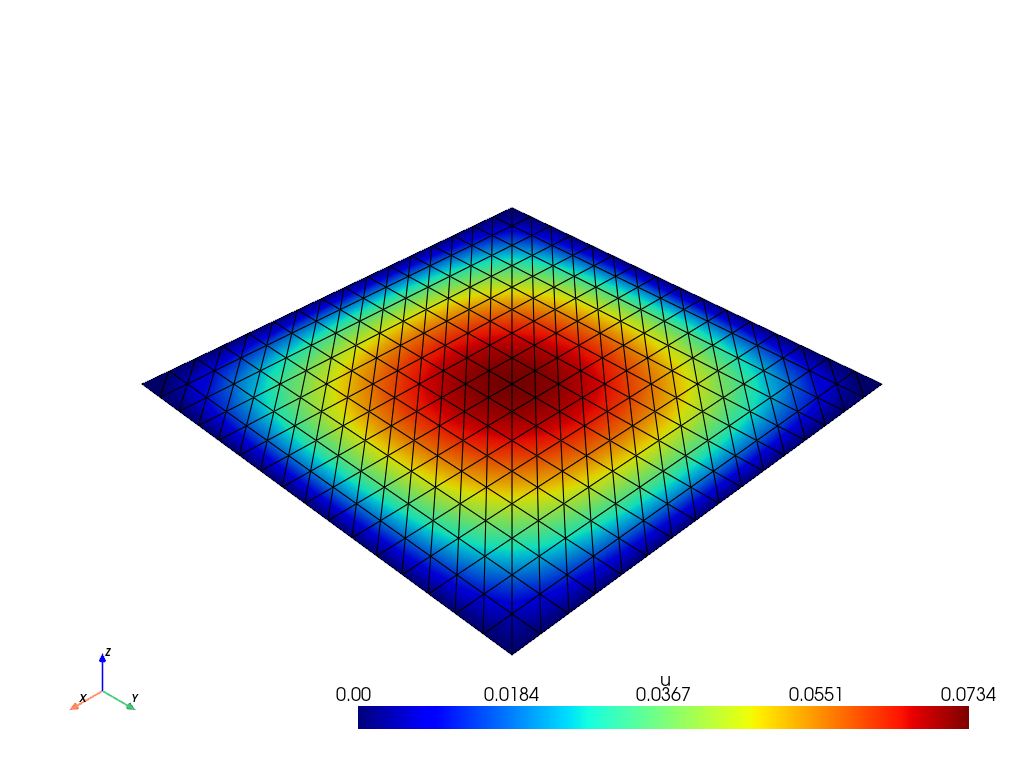

In [16]:
result = pyvista.read(solFileName + ".vtu")
result.plot(scalars="u", show_edges=True, cmap='jet')

b) Right hand side $b$ and matrix $A$

In [17]:
solFileName = "tmp/fem01_rhs_b"
ug4.WriteGridFunctionToVTK(b, solFileName)
ug4.SaveVectorForConnectionViewer(b, solFileName + ".vec")
ug4.SaveMatrixForConnectionViewer(x, A, "tmp/fem01_matrix_A.mat")

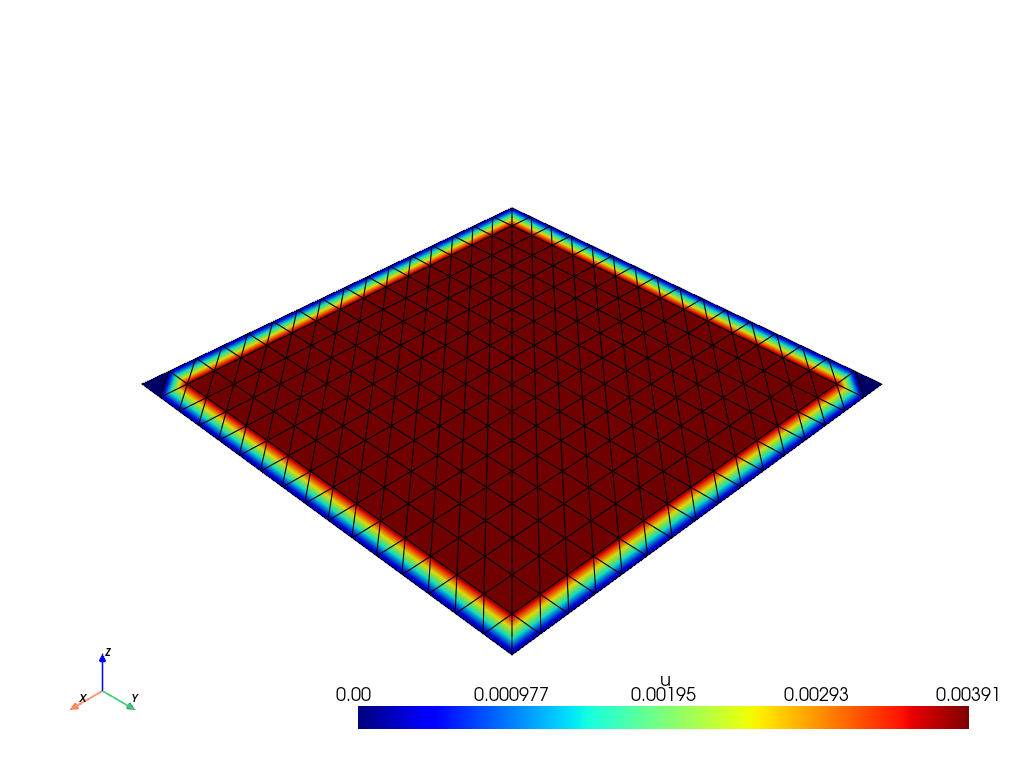

In [18]:
result = pyvista.read(solFileName + ".vtu")
result.plot(scalars="u", show_edges=True, cmap='jet')